# UCLA Results Validation

This notebook is aimed at attemping to validate the results achieved by UCLA in their paper

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [103]:
from protestDB import cursor
from protestDB import models
from lib import analysis_utils as au
import pandas as pd
import random
import os
from PIL import Image
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from keras.preprocessing.image import ImageDataGenerator
import scipy
from keras.models import Model
from keras import backend as K
from keras.applications import ResNet50
from keras.layers import Dense, Input, Flatten
from keras import losses
import h5py
import matplotlib.pyplot as plt

### Retrieve a sample of 500 images

In [47]:
# Take a sample of 500 images and their respective labels
pc = cursor.ProtestCursor()
imgs = pc.query(models.Images).filter(models.Images.source == 'UCLA')


Get the labels

In [48]:

# values of violence = 2 are gonna be masked
headers = ["fname", "protest", "violence", "sign", "photo", "fire", "police", "children", "group_20", "group_100", "flag", "night", "shouting"]
df = pd.DataFrame(columns=headers)
indx_non_violence = []

for indx, im in enumerate(imgs[:300]):
    tags = im.tags
    values = {}
    values['fname'] = im.name
    
    label = im.labels
    if len(label) == 1:
        values['violence'] = label[0].label
    elif len(label) == 0:
        values['violence'] = 0
        indx_non_violence.append(indx) # save the index of a image without label for later removing value
    else:
        raise ValueError("there should not be more than one label")
    
    for tag in tags:
        if tag.tagName == 'ucla-test': continue # ignore this
        values[tag.tagName] = 1
    
    df = df.append(values, ignore_index=True)




In [49]:
# Apply a cut point and normalize violence scores
cutpoint = 0.6

#cutpoint 
ix_large = df[df['violence'] > cutpoint].index
df.loc[ix_large, 'violence'] = cutpoint

# normalize
v = np.matrix(df['violence'])
scaler = MinMaxScaler()
df['violence'] = scaler.fit_transform(v.T)

# mask values that did not had violence labels
df.loc[indx_non_violence, 'violence'] = -1

In [50]:
df = df.fillna(0)
df

,fname,protest,violence,sign,photo,fire,police,children,group_20,group_100,flag,night,shouting
0,test-00000.jpg,1,0.632513,1,0.0,0.0,0.0,0.0,1,1,0.0,1,0.0
1,test-00001.jpg,0,-1.000000,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0
2,test-00002.jpg,1,0.370518,1,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0
3,test-00003.jpg,0,-1.000000,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0
4,test-00004.jpg,0,-1.000000,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0
5,test-00005.jpg,0,-1.000000,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0
6,test-00006.jpg,0,-1.000000,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0
7,test-00007.jpg,0,-1.000000,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0
8,test-00008.jpg,0,-1.000000,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0
9,test-00009.jpg,0,-1.000000,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0


Get the images

In [51]:
image_dir = "../images/"
np_imgs = []
for indx, row in df.iterrows():
    path = os.path.join(image_dir, row['fname'])
    img = Image.open(path)
    img_array = np.array(img)
    np_imgs.append(img_array)
np_imgs = np.array(np_imgs)

In [52]:
np_imgs.shape

(300,)

In [53]:
# Resize images
new_shape = (224,224,3)
np_imgs_resized = np.empty(shape=(np_imgs.shape[0],)+new_shape)
for idx in range(np_imgs.shape[0]):
    np_imgs_resized[idx] = scipy.misc.imresize(np_imgs[idx], new_shape)

/home/lucas/Documents/ITU/Thesis_2018/venv/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


In [54]:
np_imgs_resized.shape

(300, 224, 224, 3)

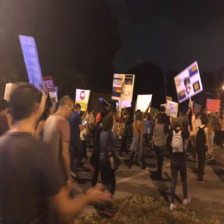

In [55]:
Image.fromarray(np_imgs_resized[0].astype('uint8'))

Select training and validation sets

In [57]:
train_X = np_imgs_resized[:100]; validation_X = np_imgs_resized[100:200]; test_X = np_imgs_resized[200:300]
print("train, validation and test image shapes", train_X.shape, validation_X.shape, test_X.shape)

train_protest = np.array(df['protest'])[0:100] ;validation_protest = np.array(df['protest'])[100:200]
test_protest = np.array(df['protest'])[200:300]
print("protest train, validation  and test shapes", train_protest.shape, validation_protest.shape, test_protest.shape)

train_violence = np.array(df['violence'])[0:100] ;validation_violence = np.array(df['violence'])[100:200]
test_violence = np.array(df['violence'])[200:300]
print("violence train, validation  and test shapes", train_violence.shape, validation_violence.shape, test_violence.shape)

train_visual = np.array(df.iloc[:,3:])[0:100] ;validation_visual = np.array(df.iloc[:,3:])[100:200]
test_visual = np.array(df.iloc[:,3:])[200:300]
print("violence train  and test shapes", train_visual.shape, validation_visual.shape, test_visual.shape)

train, validation and test image shapes (100, 224, 224, 3) (100, 224, 224, 3) (100, 224, 224, 3)
protest train, validation  and test shapes (100,) (100,) (100,)
violence train, validation  and test shapes (100,) (100,) (100,)
violence train  and test shapes (100, 10) (100, 10) (100, 10)


### Modeling

In [160]:


def build_masked_loss(loss_function, mask_value):
    """Builds a loss function that masks based on targets

    Args:
        loss_function: The loss function to mask
        mask_value: The value to mask in the targets

    Returns:
        function: a loss function that acts like loss_function with masked inputs
    """

    def masked_loss_function(y_true, y_pred):
        mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
        return loss_function(y_true * mask, y_pred * mask)

    return masked_loss_function



In [ ]:
def scheduler(epoch):
    if epoch == 5:
        model.lr.set_value(.02)
    return model.lr.get_value()

change_lr = LearningRateScheduler(scheduler)

model.fit(x_embed, y, nb_epoch=1, batch_size = batch_size, show_accuracy=True,
       callbacks=[chage_lr])

In [161]:
n_images = np_imgs_resized.shape[0]
mask_value = -1
K.clear_session()

In [162]:
# testing it works
resnet_model = ResNet50(include_top=False, weights = None, input_shape = (224,224,3))
features = resnet_model.predict(np_imgs_resized[0].reshape(1,224,224,3))
print(features.shape)

(1, 1, 1, 2048)


In [163]:
img_input = Input(shape=(224,224,3), name='img_input')
resnet_model = ResNet50(include_top=False, weights = None) (img_input)
flatten = Flatten()(resnet_model)
protest_out = Dense(1, activation='sigmoid', name='protest_out')(flatten)
visual_out = Dense(10, activation='sigmoid', name='visual_out')(flatten)
violence_out = Dense(1, activation='sigmoid', name='violence_out')(flatten)

model = Model(inputs= img_input, outputs=[protest_out, visual_out, violence_out])
model.compile(optimizer='rmsprop',
              loss={'protest_out': build_masked_loss(losses.binary_crossentropy, mask_value),
                    'visual_out': build_masked_loss(losses.binary_crossentropy, mask_value), 
                    'violence_out': build_masked_loss(losses.mean_squared_error, mask_value)},
              loss_weights={'protest_out': 1., 
                            'visual_out': 1, 
                            'violence_out': 1 })
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
resnet50 (Model)                multiple             23587712    img_input[0][0]                  
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 2048)         0           resnet50[1][0]                   
__________________________________________________________________________________________________
protest_out (Dense)             (None, 1)            2049        flatten_1[0][0]                  
__________________________________________________________________________________________________
visual_out

In [164]:
history = model.fit({'img_input': train_X},
          {'protest_out': train_protest, 'visual_out': train_visual, 'violence_out': train_violence},
          validation_data= (validation_X, [validation_protest, validation_visual, validation_violence]),
          epochs=5, batch_size=32)

Train on 100 samples, validate on 100 samples
Epoch 1/5
100/100 [==============================] - 123s 1s/step - loss: 2.4305 - protest_out_loss: 1.9515 - visual_out_loss: 0.4549 - violence_out_loss: 0.0241 - val_loss: 4.2583 - val_protest_out_loss: 3.5747 - val_visual_out_loss: 0.6596 - val_violence_out_loss: 0.0240
Epoch 2/5
100/100 [==============================] - 117s 1s/step - loss: 0.9449 - protest_out_loss: 0.7250 - visual_out_loss: 0.2086 - violence_out_loss: 0.0113 - val_loss: 2.3306 - val_protest_out_loss: 1.9371 - val_visual_out_loss: 0.3748 - val_violence_out_loss: 0.0187
Epoch 3/5
100/100 [==============================] - 114s 1s/step - loss: 1.1278 - protest_out_loss: 0.8857 - visual_out_loss: 0.2280 - violence_out_loss: 0.0141 - val_loss: 1.8202 - val_protest_out_loss: 1.3615 - val_visual_out_loss: 0.4135 - val_violence_out_loss: 0.0453
Epoch 4/5
100/100 [==============================] - 119s 1s/step - loss: 1.0157 - protest_out_loss: 0.7643 - visual_out_loss: 0.232

### Test set evaluation

In [165]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
def plot_roc(attr, target, pred):
    """Plot a ROC curve and show the accuracy score and the AUC"""
    fig, ax = plt.subplots()
    auc = roc_auc_score(target, pred)
    acc = accuracy_score(target, (pred >= 0.5).astype(int))
    fpr, tpr, _ = roc_curve(target, pred)
    plt.plot(fpr, tpr, lw = 2, label = attr.title())
    plt.legend(loc = 4, fontsize = 15)
    plt.title(('ROC Curve for {attr} (Accuracy = {acc:.3f}, AUC = {auc:.3f})'
               .format(attr = attr.title(), acc= acc, auc = auc)),
              fontsize = 15)
    plt.xlabel('False Positive Rate', fontsize = 15)
    plt.ylabel('True Positive Rate', fontsize = 15)
    plt.show()
    return fig

In [166]:
preds = model.predict(test_X); preds_protest = preds[0]; preds_visual = preds[1]; preds_violence = preds[2]

### Protest

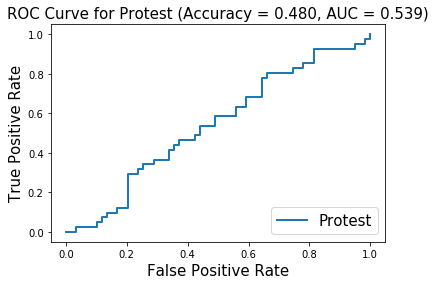

In [169]:
attr = "protest"
plot_roc(attr, test_protest, preds_protest)

### Visual

sign


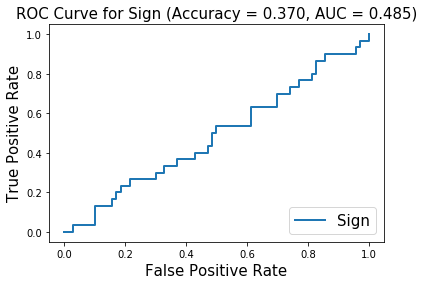

photo


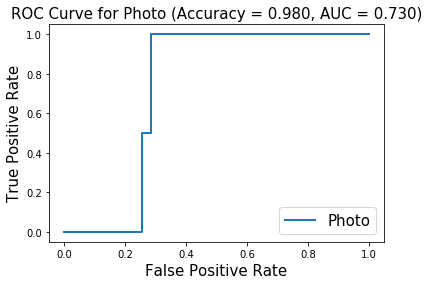

fire


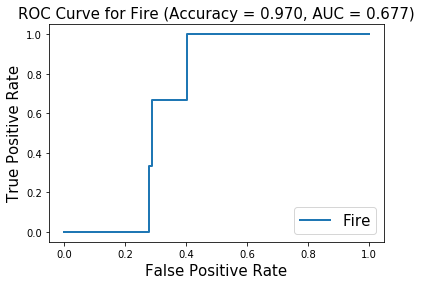

police


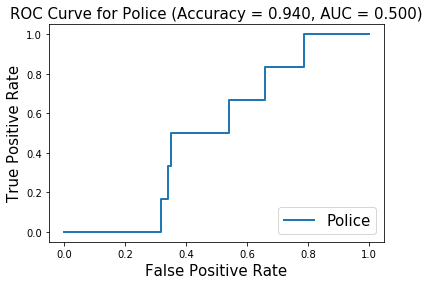

children
Only one class present in y_true. ROC AUC score is not defined in that case.
group_20


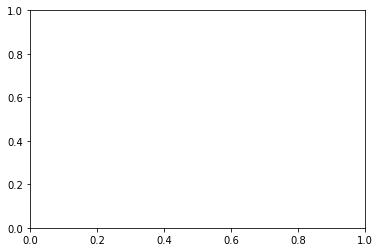

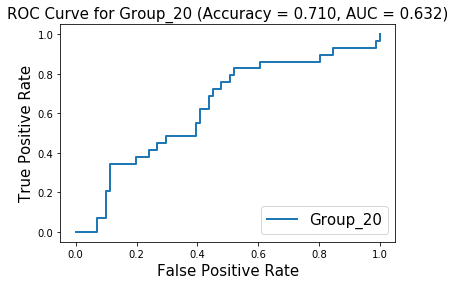

group_100


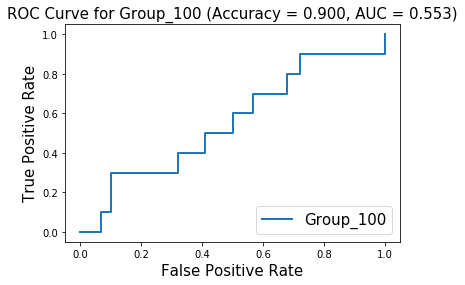

flag


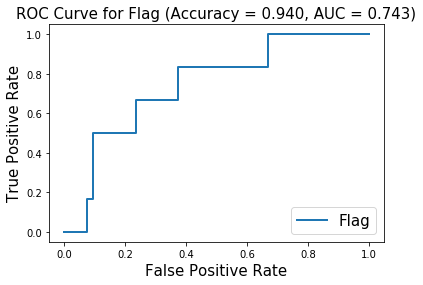

night


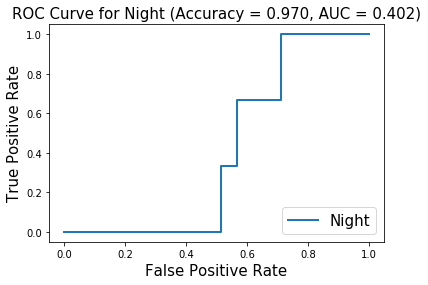

shouting


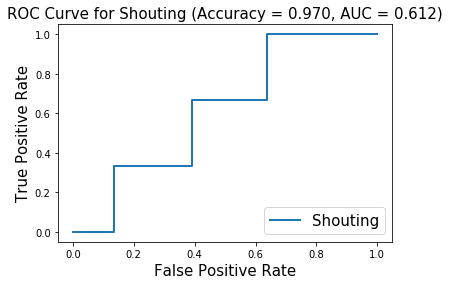

In [195]:
for i in range(preds_visual.shape[1]):
    pred = preds_visual[:,i]
    target = test_visual[:,i]
    attr_indx = 3 + i # the visual attributes start from the 4th pos
    attr = df.columns[attr_indx]
    print(attr)
    try:
        plot_roc(attr, target, pred)
    except Exception as e:
        print(e)

### Violence

In [167]:
non_masked_violence_true = test_violence[test_violence!= -1].tolist()
non_masked_violence_preds = preds_violence[test_violence!= -1].flatten().tolist()

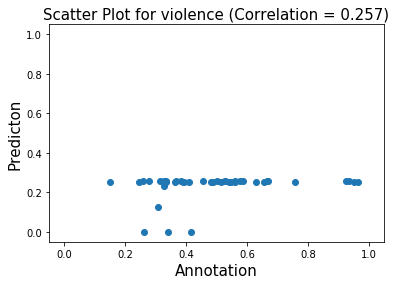

In [168]:
import scipy.stats as stats
fig, ax = plt.subplots()
plt.scatter(non_masked_violence_true, non_masked_violence_preds, label = "violence")
plt.xlim([-.05,1.05])
plt.ylim([-.05,1.05])
plt.xlabel('Annotation', fontsize = 15)
plt.ylabel('Predicton', fontsize = 15)
corr, pval = stats.pearsonr(non_masked_violence_true, non_masked_violence_preds)
plt.title(('Scatter Plot for {attr} (Correlation = {corr:.3f})'
            .format(attr = "violence", corr= corr)), fontsize = 15)
plt.show()